Creation of table with DE genes and log fold change 

In [2]:
import glob
import re
import pandas as pd

def get_files(directory, factor):
    return [f for f in glob.glob(directory + '/' + '*' + '.with_genes.sig_DE.txt') if f.startswith(directory + '/' + factor)]


def clean_columns(f):
    return '.'.join(f.split('/')[-1].split('_')[:1])

factor_files = {
    'mmTreg': get_files('/data/reddylab/Revathy/dev/rna-seq_Siklenka/results/rna_seq', 'mmTreg'),
    'Th17': get_files('/data/reddylab/Revathy/dev/rna-seq_Siklenka/results/rna_seq', 'Th17'),
    'pTh17': get_files('/data/reddylab/Revathy/dev/rna-seq_Siklenka/results/rna_seq', 'pTh17')
}

def merge_files(files, factor):
    df = None
    for fact, file in files.items():
        if fact is factor:
            for f in file:
                df_tmp = pd.read_csv(f, sep = '\t')
                if 'stat' in df_tmp.columns.tolist():
                    df_tmp.drop(columns = ['Unnamed: 0', 'baseMean', 'lfcSE', 'pvalue', 'padj', 'GeneType', 'stat'], inplace = True)
                else:
                    df_tmp.drop(columns = ['Unnamed: 0', 'baseMean', 'lfcSE', 'pvalue', 'padj', 'GeneType'], inplace = True)
                df_tmp = df_tmp[['GeneName', 'log2FoldChange']]
                df_tmp.columns = df_tmp.columns[:-1].tolist() + [clean_columns(f)]
                if df is None:
                    df = df_tmp
                else:
                    df = df.merge(df_tmp, how = 'outer', on = 'GeneName')
               
            df = df[['GeneName','%s.Bulk.00hr'%fact,'%s.Bulk.02hr'%fact,'%s.Bulk.16hr'%fact,'%s.Bulk.24hr'%fact,'%s.Bulk.48hr'%fact,'%s.Bulk.72hr'%fact]]
    #df.to_csv('/data/reddylab/Revathy/dev/rna-seq_Siklenka/results/rna_seq/clustering/%s.logFC.txt' % factor, sep='\t')  
    return df

In [3]:
mmTreg = merge_files(factor_files, 'mmTreg')
Th17 = merge_files(factor_files, 'Th17')
pTh17 = merge_files(factor_files, 'pTh17')

Hierarchical clustering- Dendrograms

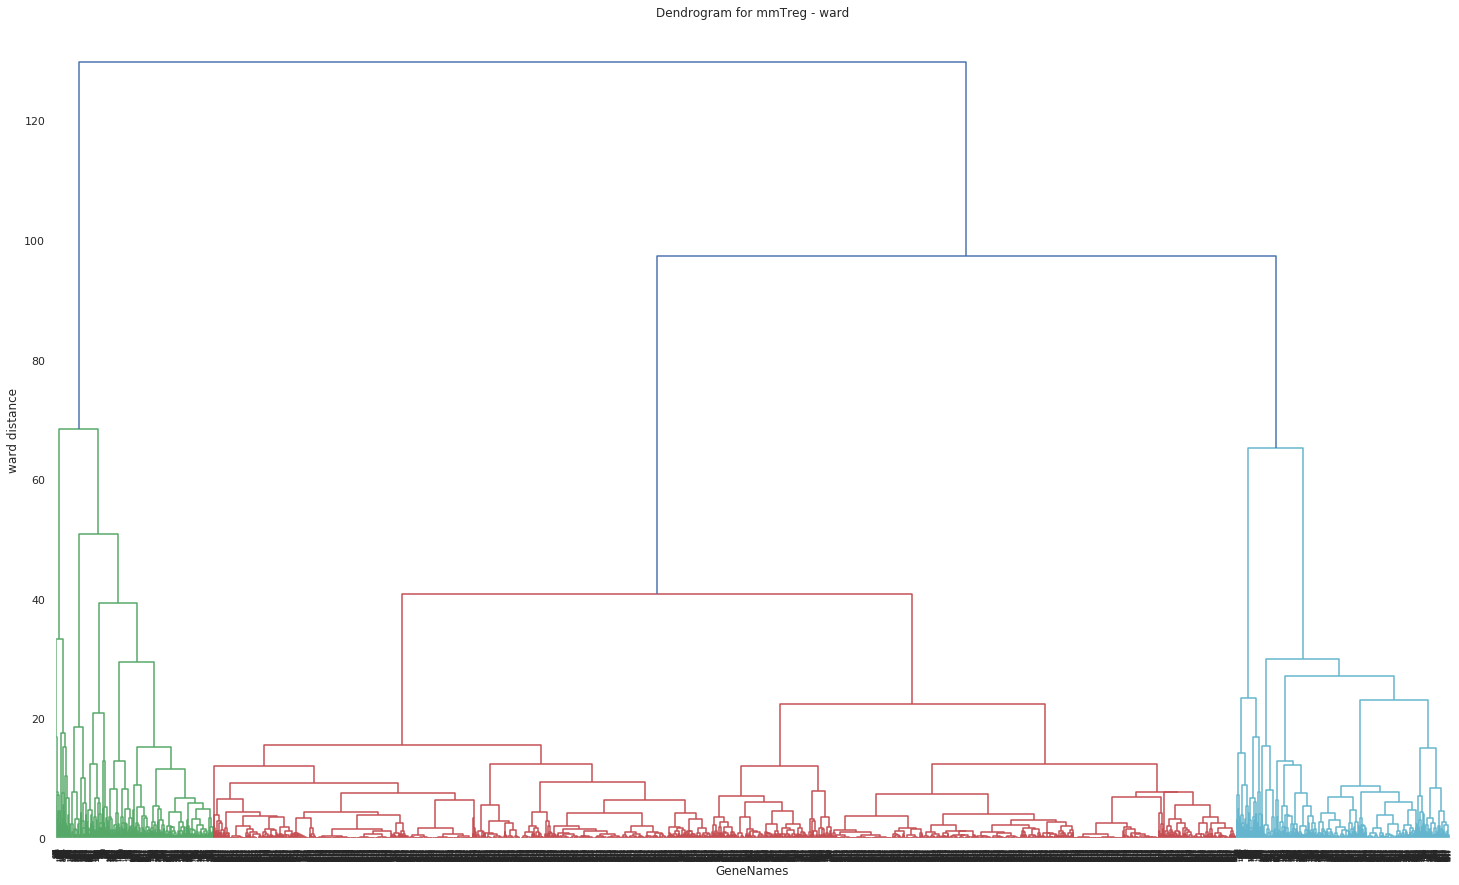

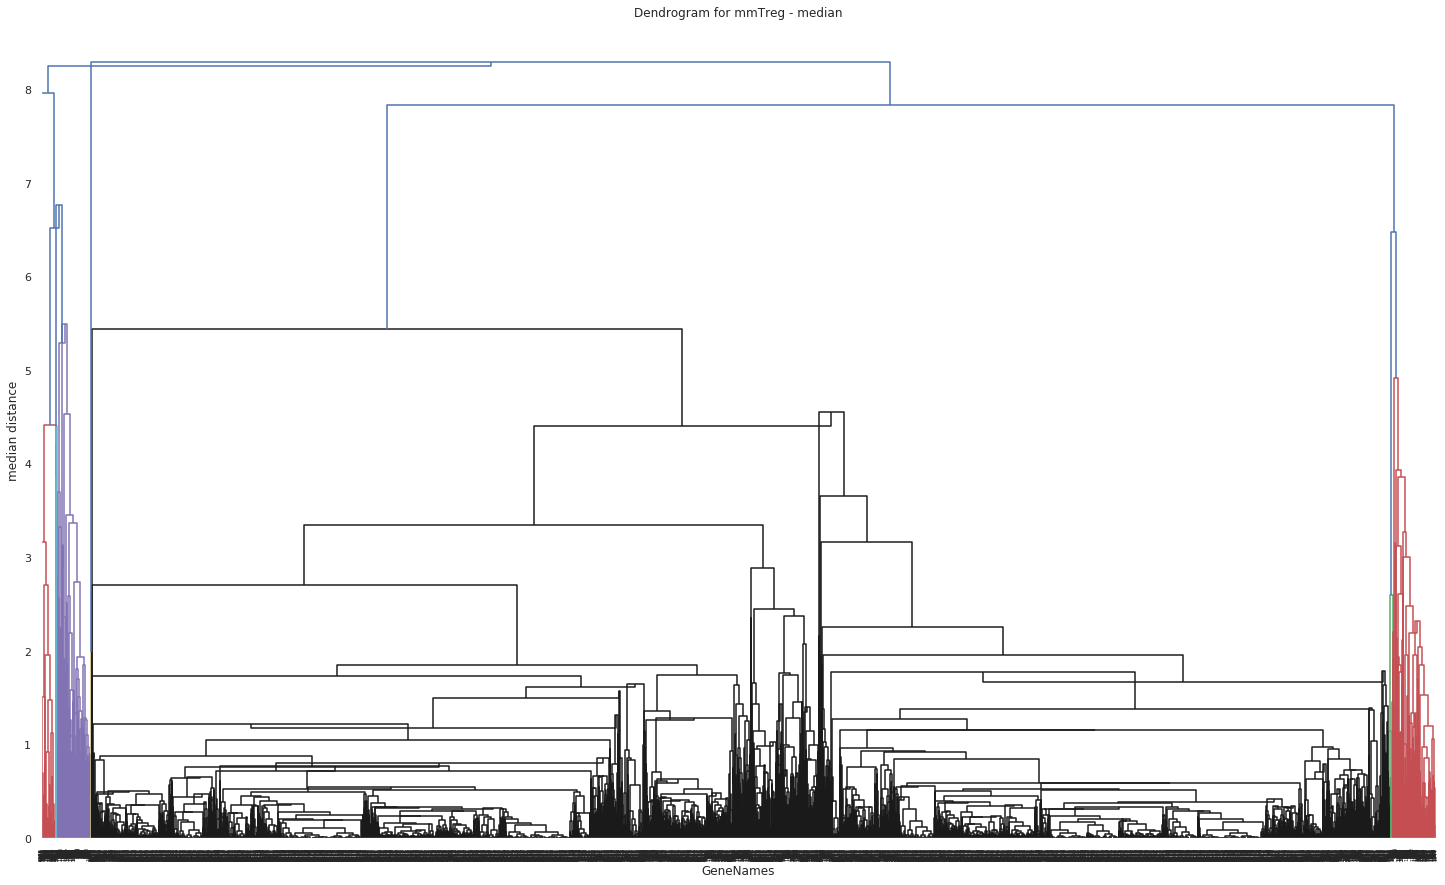

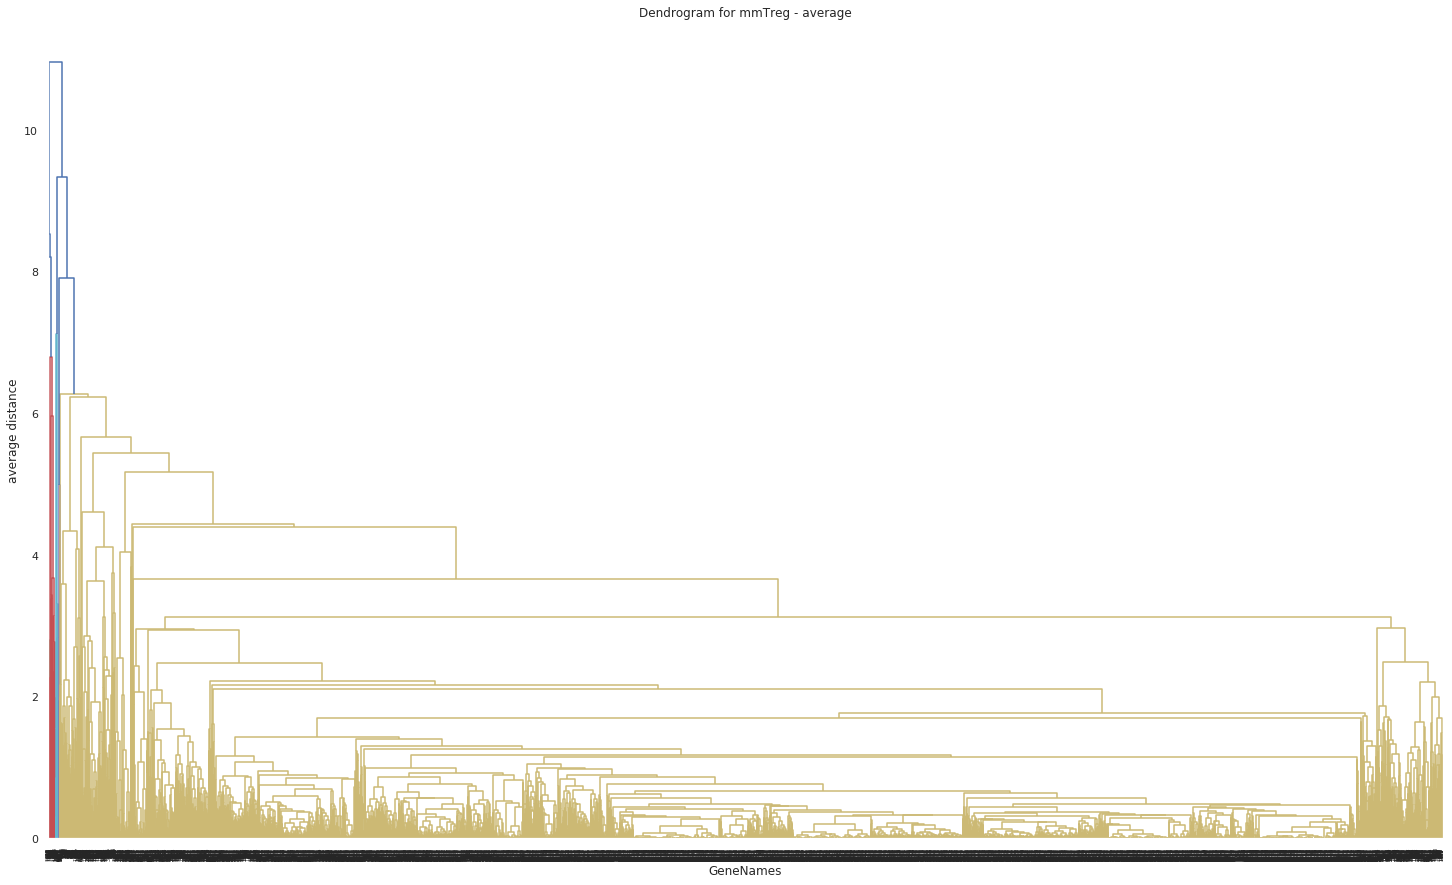

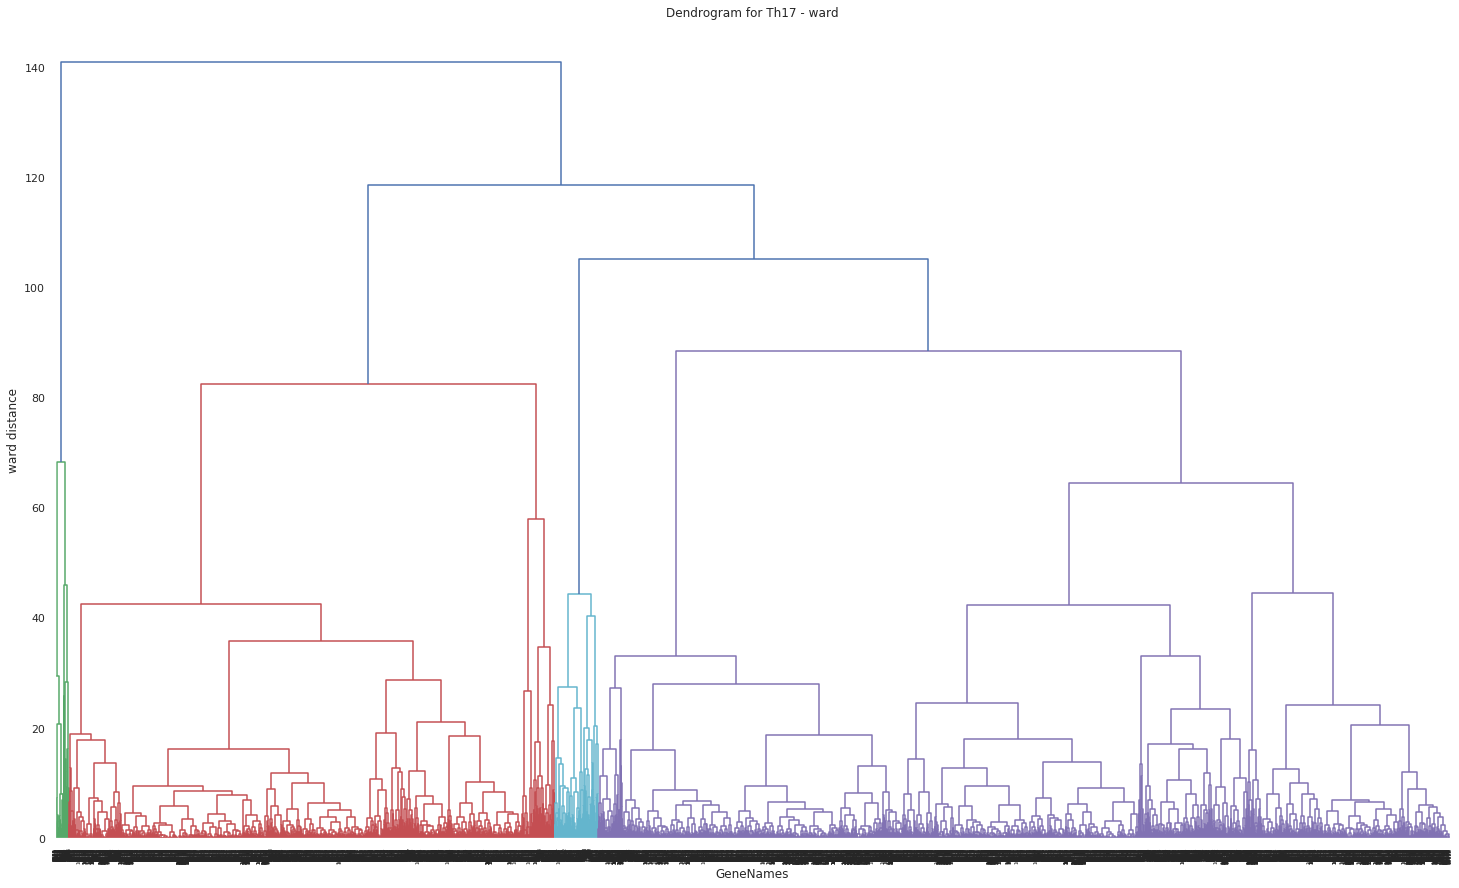

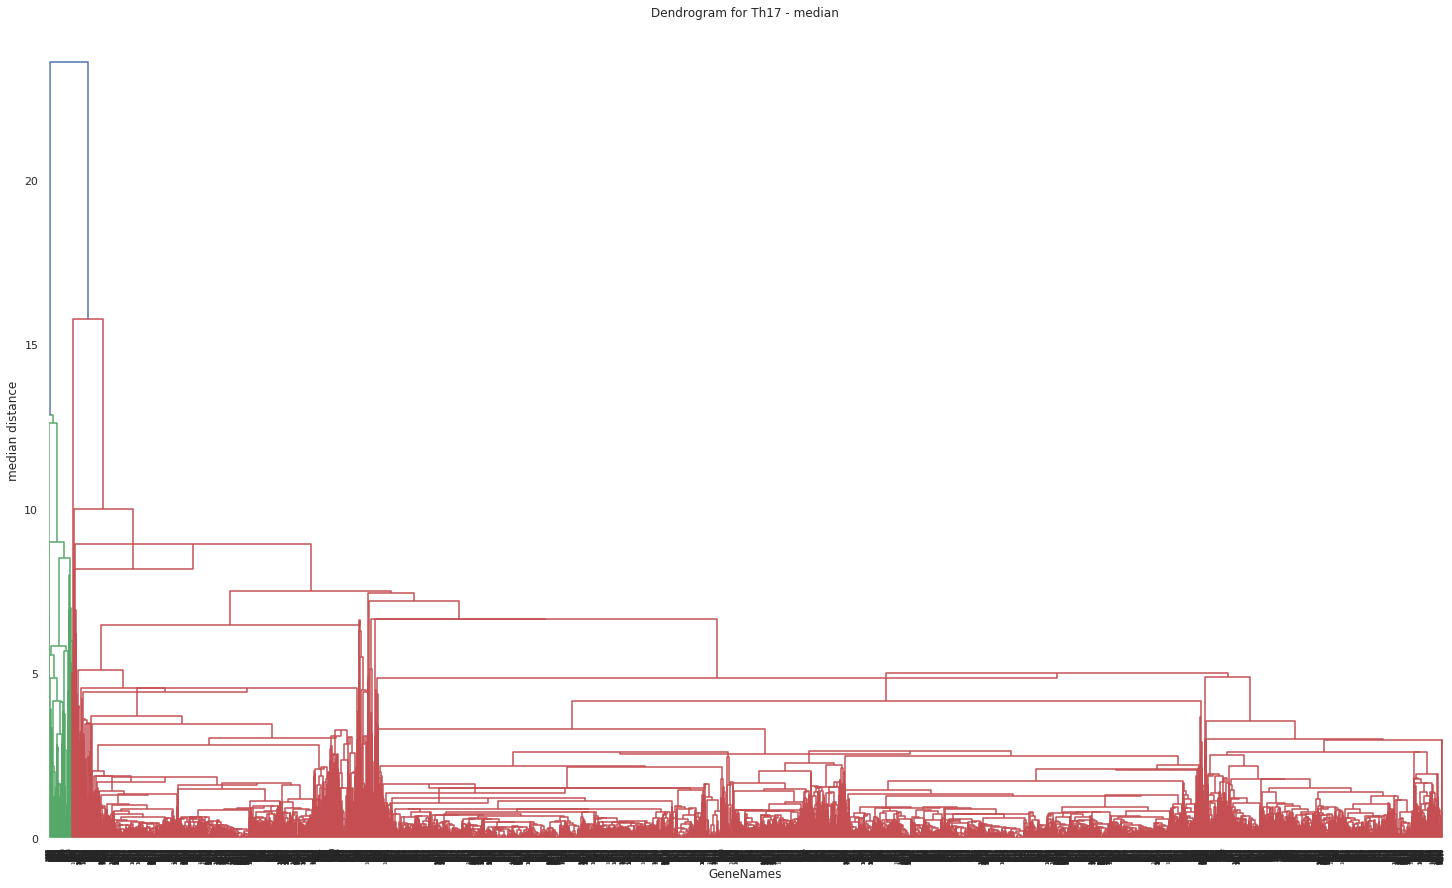

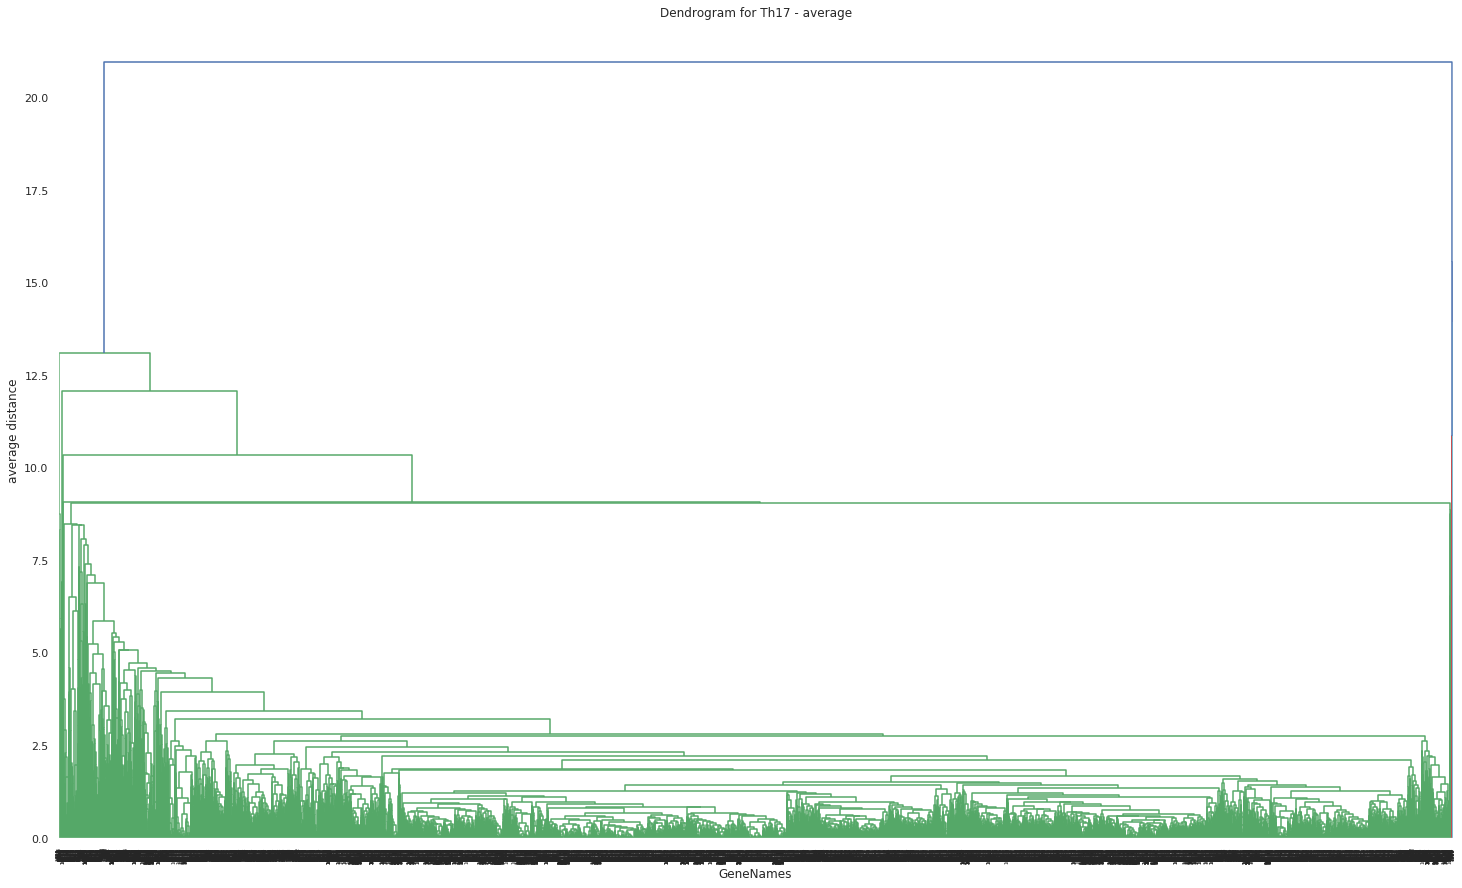

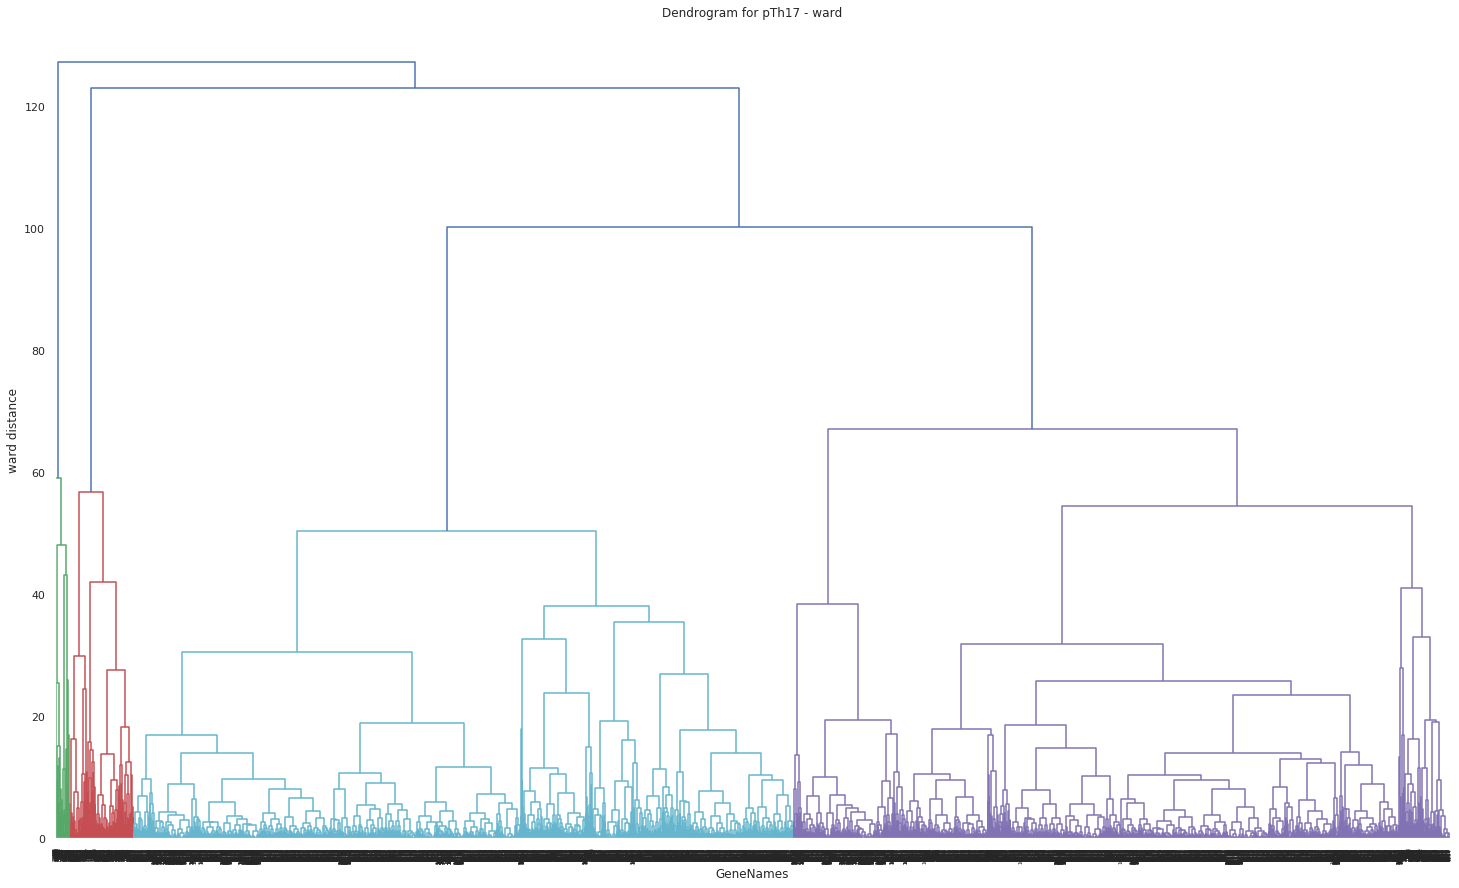

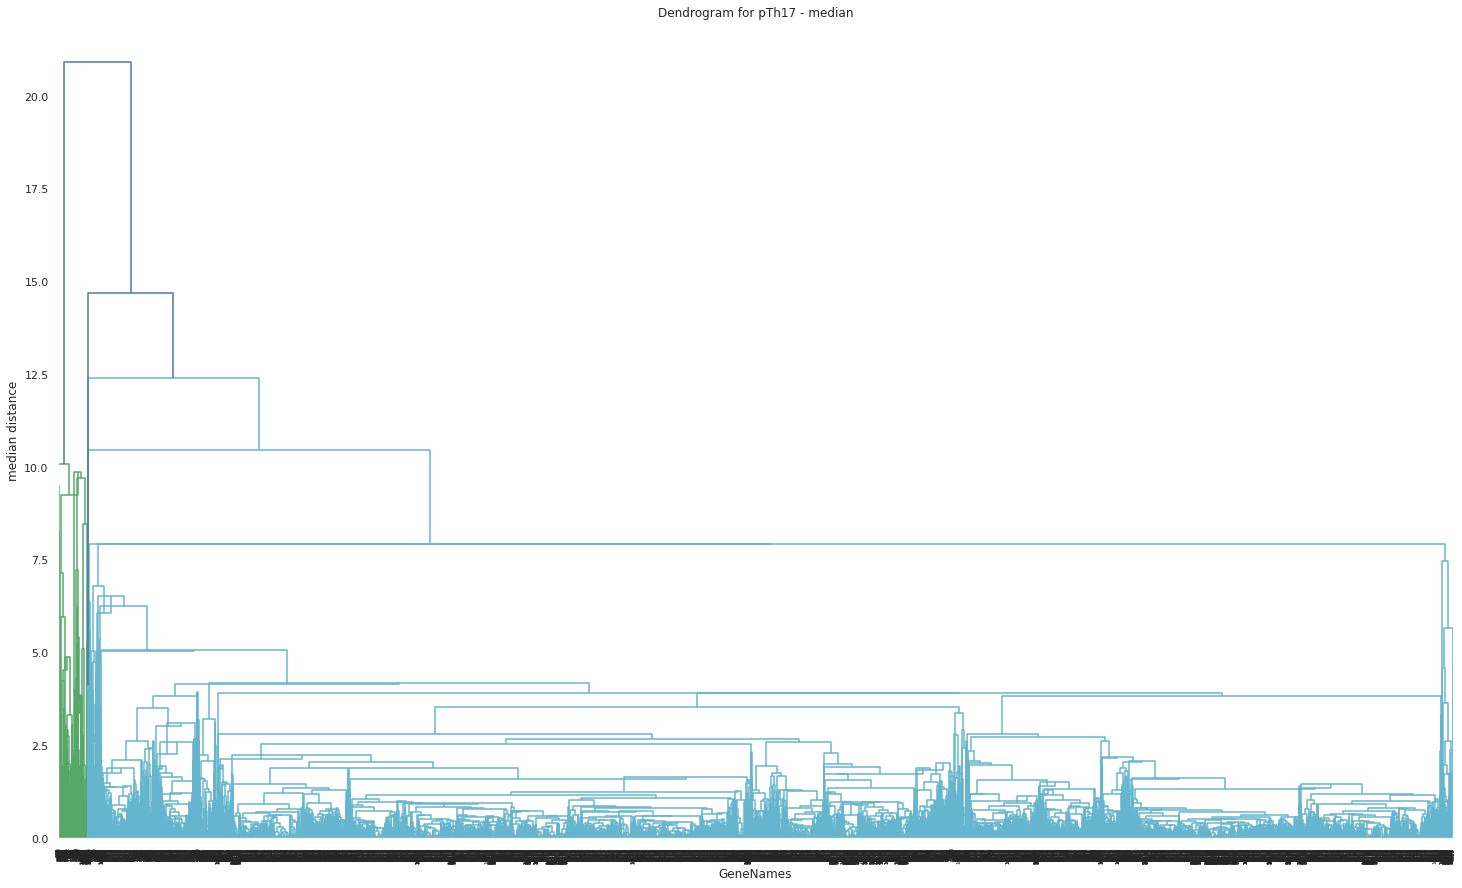

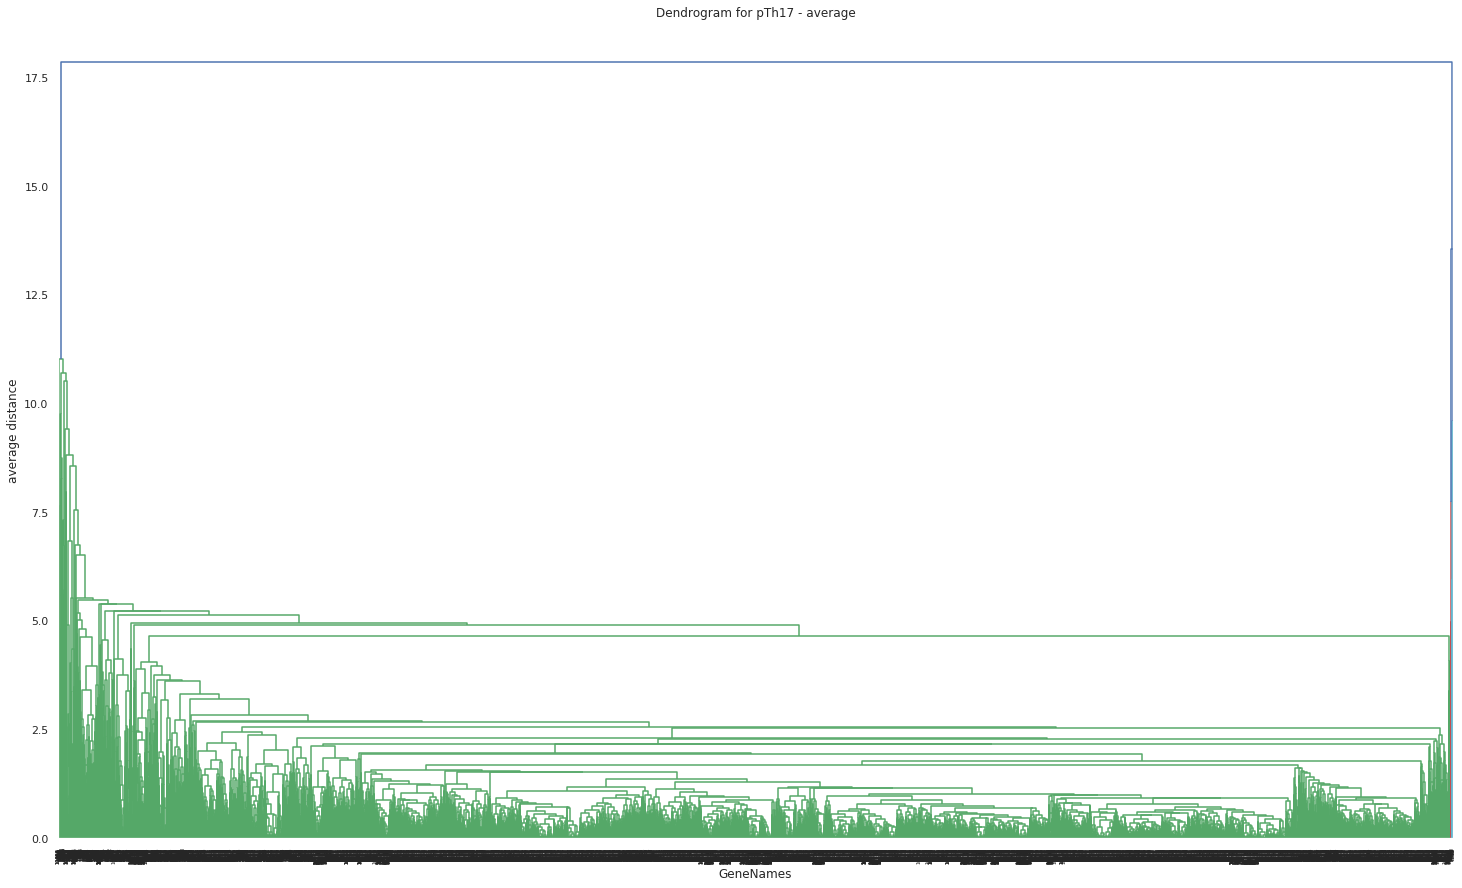

In [30]:
import scipy.cluster.hierarchy as sch
#from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


factors = ['mmTreg', 'Th17', 'pTh17']
directory = '/data/reddylab/Revathy/dev/rna-seq_Siklenka/results/rna_seq/clustering'
special_genes = ['Maf', 'Il17a', 'Rorc', 'Stat3', 'Stat5', 'Batf', 'Irf4', 'Runx1', 'Il21r', 'Tbx21', 'Foxp3']


for factor in factors:
    df = pd.read_csv("%s/%s.logFC.txt" % (directory, factor),
                    sep="\t")
    
    df = df.fillna(0)
    #df = df[['GeneName','%s.Bulk.00hr'%factor,'%s.Bulk.02hr'%factor,'%s.Bulk.16hr'%factor,'%s.Bulk.24hr'%factor,'%s.Bulk.48hr'%factor,'%s.Bulk.72hr'%factor]]
    #df = df.head(1000)
    df_X = df.iloc[:, [1,2,3,4,5,6]].values
    #df_sp_genes = df[df.GeneName.isin(special_genes)]
    #display(df_sp_genes)
    #df_y = df_sp_genes.iloc[:, [1,2,3,4,5,6]].values
    
    #df = df.set_index('GeneName')
    #df_sp_genes = df_sp_genes.set_index('GeneName')
    
    methods = ['ward','median','average']
    
    for method in methods:
        fig = plt.figure(figsize=(25,15))
        ax1 = plt.subplot(1,1,1)
        plt.title('Dendrogram for %s - %s' % (factor, method))
        df_link = sch.linkage(df_X, method  = method)
        dendrogram = sch.dendrogram(df_link)
        if 'ward' in method:
            labels = sch.fcluster(df_link, 10, criterion='distance')
        else:
            labels = sch.fcluster(df_link, 2, criterion='distance')
        
        df_label = pd.DataFrame({'labels': labels, 'GeneName': df.GeneName})
        ct = pd.crosstab(df_label['labels'], df_label['GeneName'])
        df_label.groupby(['labels'])
        cluster_dict = df_label.groupby(['labels'])['GeneName'].apply(list).to_dict()
        f = open("/data/reddylab/Revathy/dev/rna-seq_Siklenka/results/rna_seq/clustering/clusters_%s_%s.txt" % (factor, method), "w")
        f.write( str(cluster_dict))
        f.close()
        
        plt.xlabel('GeneNames')
        plt.ylabel('%s distance' % method)
        #plt.axhline(y=, color='b', linestyle='--')
        plt.savefig('/data/reddylab/Revathy/dev/rna-seq_Siklenka/results/rna_seq/clustering/Dendrogram for %s - %s.png' % (factor, method))
        
        plt.show()
        


Hierarchical clustering - Dendrograms for genes of interest

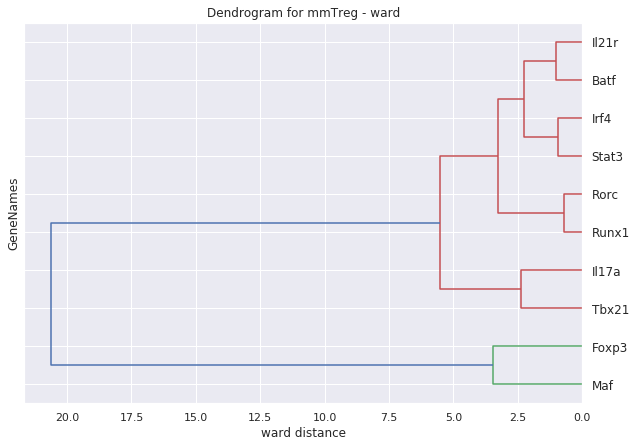

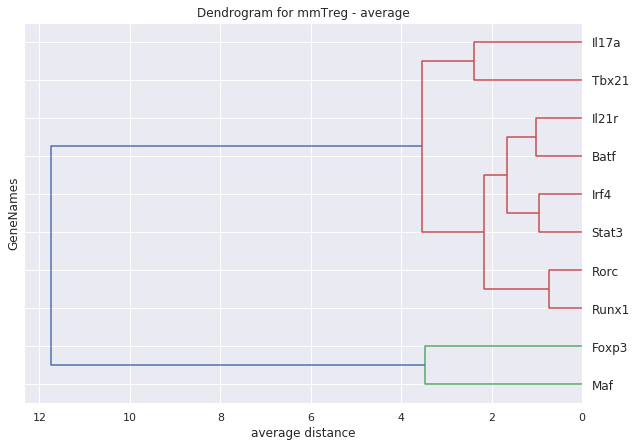

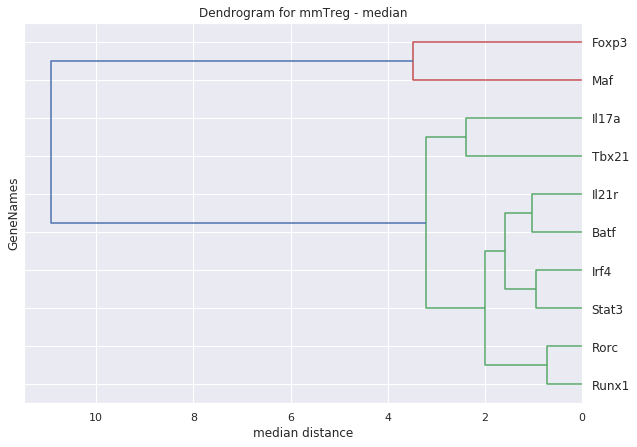

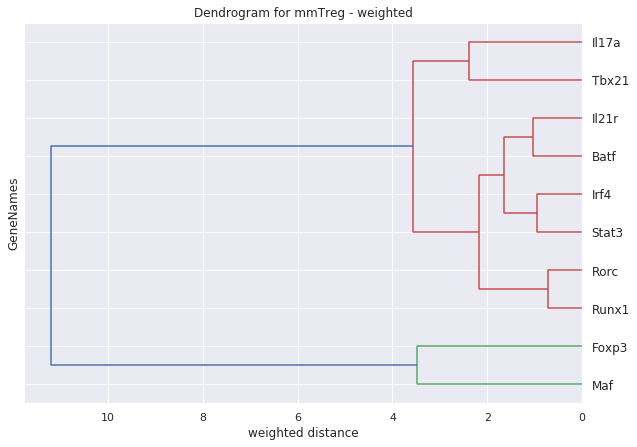

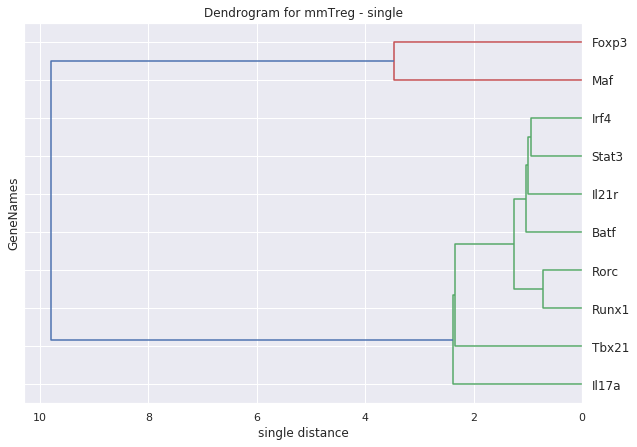

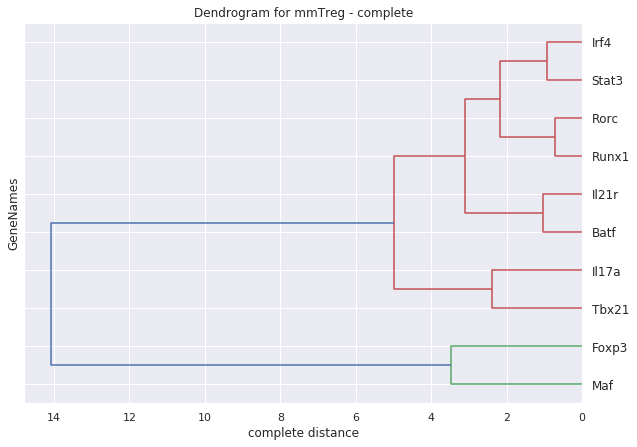

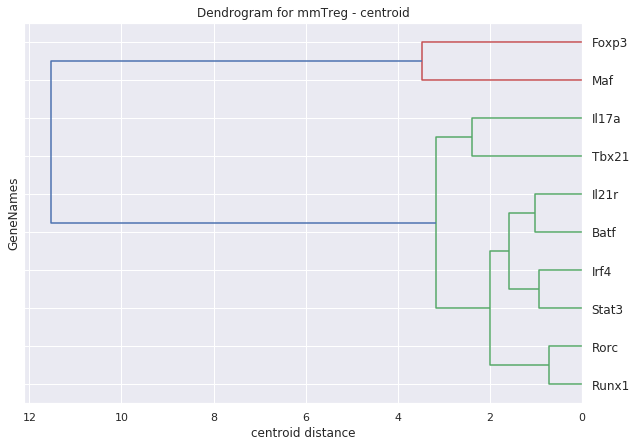

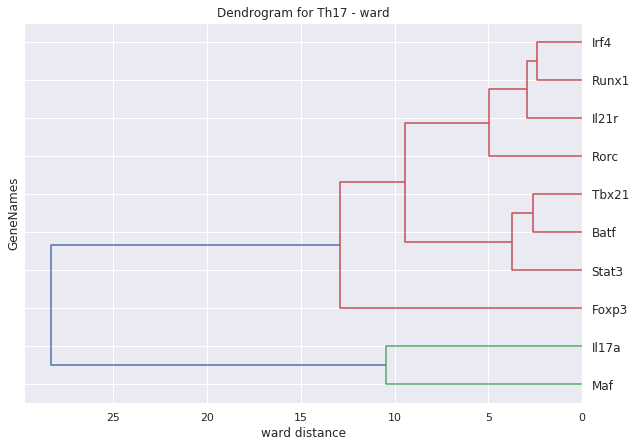

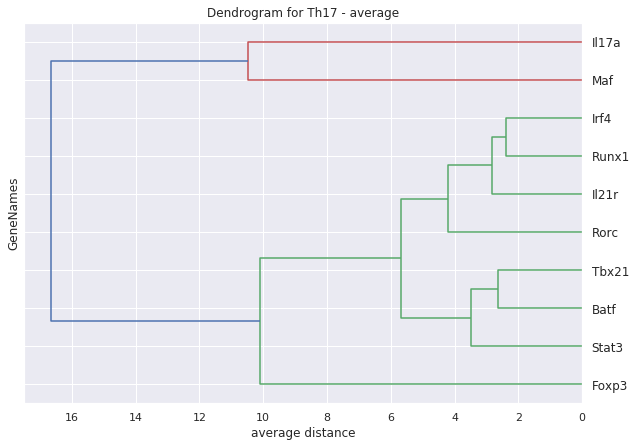

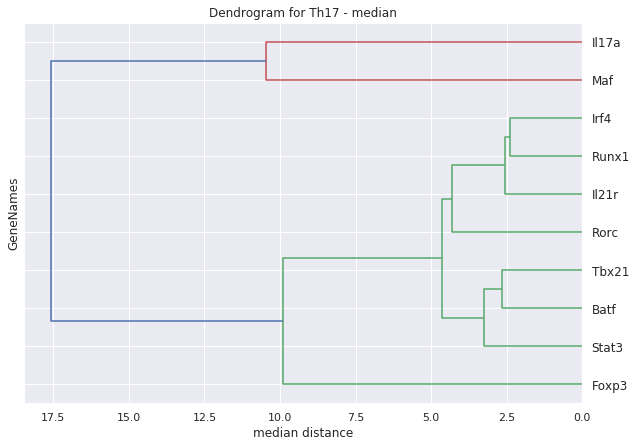

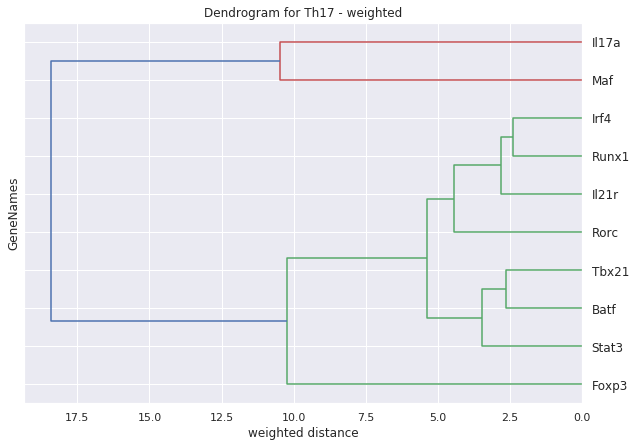

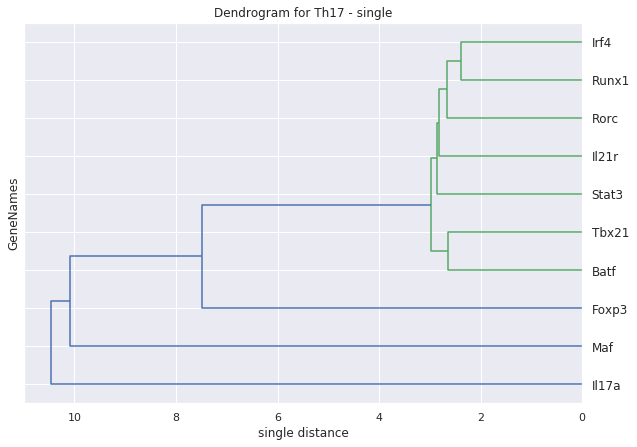

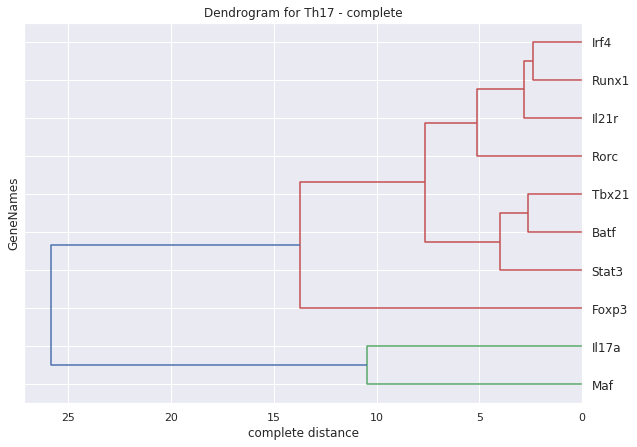

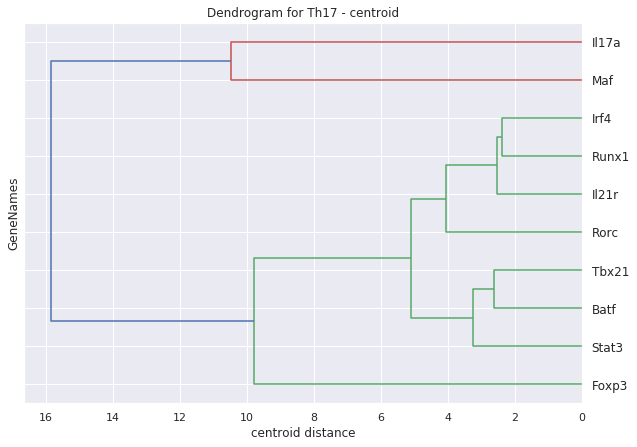

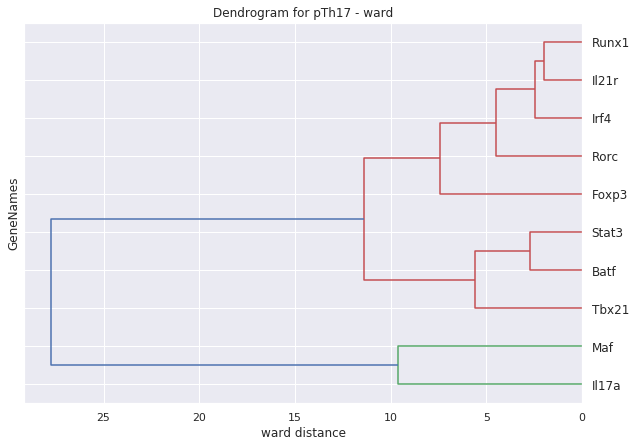

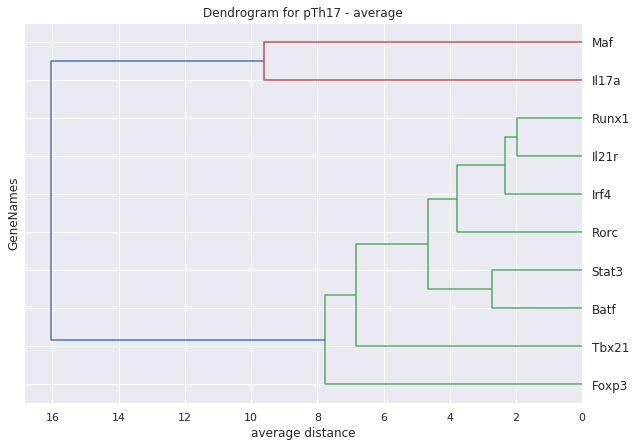

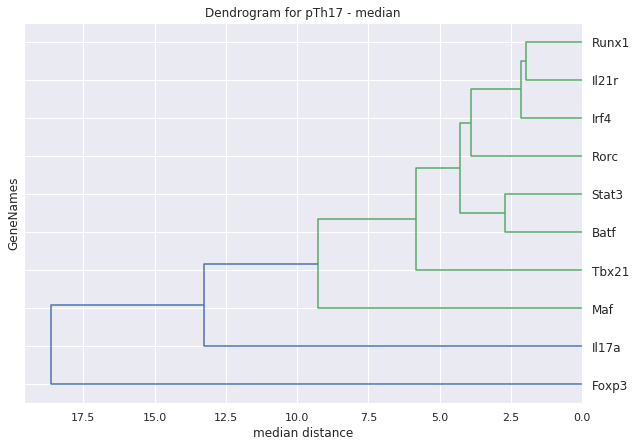

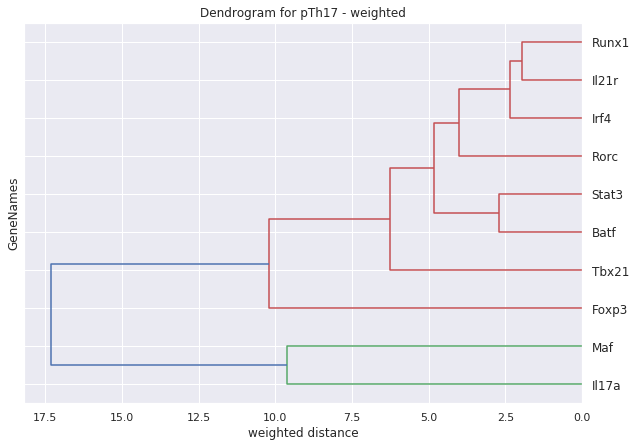

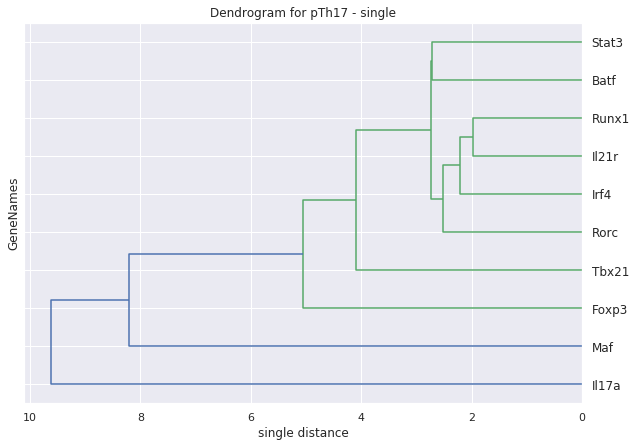

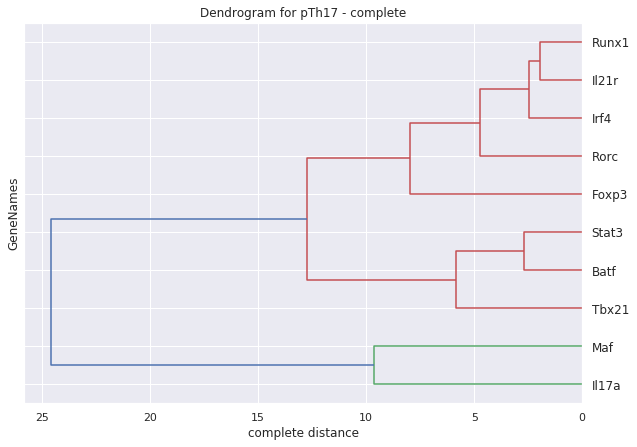

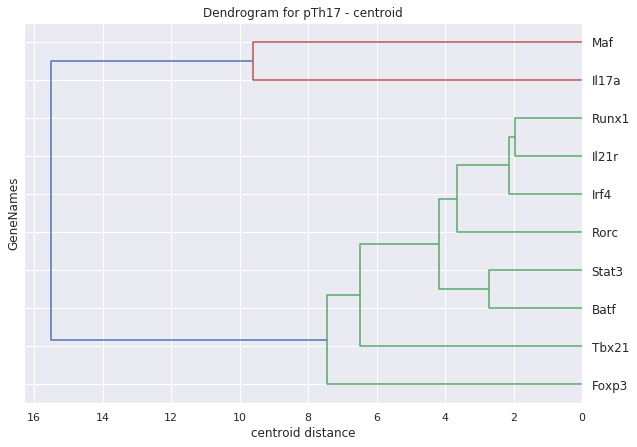

In [7]:
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


factors = ['mmTreg', 'Th17', 'pTh17']
directory = '/data/reddylab/Revathy/dev/rna-seq_Siklenka/results/rna_seq/clustering'
special_genes = ['Maf', 'Il17a', 'Rorc', 'Stat3', 'Stat5', 'Batf', 'Irf4', 'Runx1', 'Il21r', 'Tbx21', 'Foxp3']


for factor in factors:
    df = pd.read_csv("%s/%s.logFC.txt" % (directory, factor),
                    sep="\t")
    
    df = df.fillna(0)
    df = df[['GeneName','%s.Bulk.00hr'%factor,'%s.Bulk.02hr'%factor,'%s.Bulk.16hr'%factor,'%s.Bulk.24hr'%factor,'%s.Bulk.48hr'%factor,'%s.Bulk.72hr'%factor]]
    df_X = df.iloc[:, [1,2,3,4,5,6]].values
    df_sp_genes = df[df.GeneName.isin(special_genes)]
    #display(df_sp_genes)
    df_y = df_sp_genes.iloc[:, [1,2,3,4,5,6]].values
    
    df = df.set_index('GeneName')
    df_sp_genes = df_sp_genes.set_index('GeneName')
    
    
    methods = ['ward', 'average']
    for method in methods:
        fig = plt.figure(figsize=(10,7))
        ax = plt.subplot(1,1,1)
        den = sch.dendrogram(sch.linkage(df_y, method  = method), labels = df_sp_genes.index, orientation="left")
        plt.title('Dendrogram for %s - %s' % (factor, method))
        plt.xlabel('%s distance' % method)
        plt.ylabel('GeneNames')
        plt.show()
    

Hierarchical clustering - clustermaps for all DE genes and genes of interest

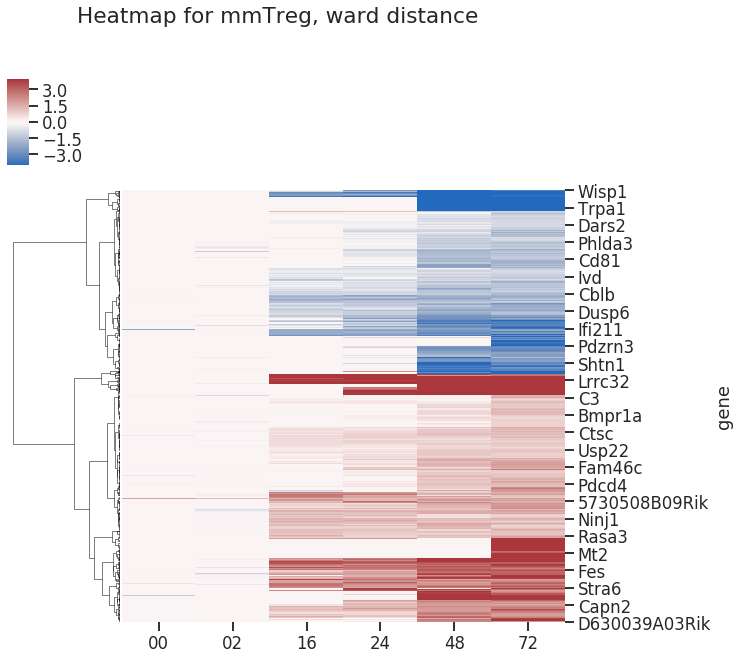

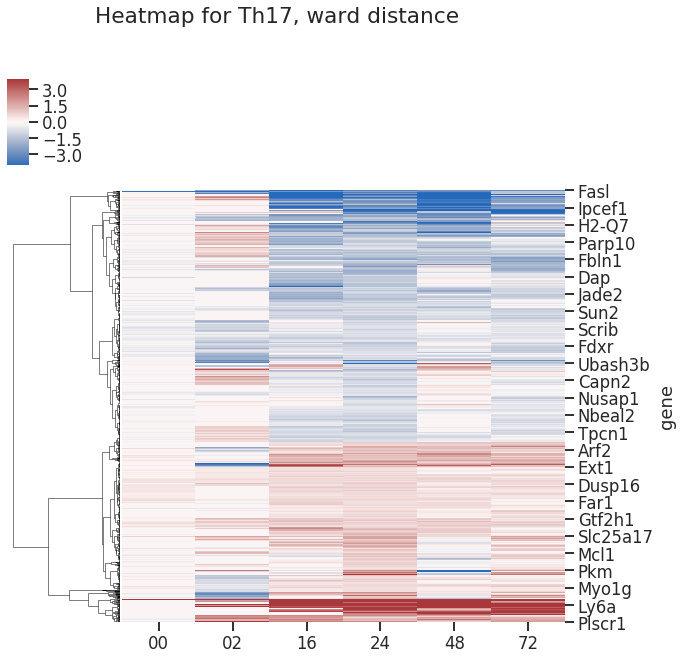

In [6]:
import scipy.cluster.hierarchy as sch
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set_context("talk")
sns.set_style("whitegrid")
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

factors = ['mmTreg', 'Th17']
directory = '/data/reddylab/Revathy/collabs/rna-seq_Siklenka/results/rna_seq/clustering'
special_genes = ['Maf', 'Il17a', 'Rorc', 'Stat3', 'Stat5', 'Batf', 'Irf4', 'Runx1', 'Il21r', 'Tbx21', 'Foxp3']


for factor in factors:
    df = pd.read_csv("%s/%s.logFC.txt" % (directory, factor),
                    sep="\t")
    
    df = df.fillna(0)
#    print(df)
#    df = df[['GeneName','%s.Bulk.00hr'%factor,'%s.Bulk.02hr'%factor,'%s.Bulk.16hr'%factor,'%s.Bulk.24hr'%factor,'%s.Bulk.48hr'%factor,'%s.Bulk.72hr'%factor]]
    df = df.head(1000)
    #df_X = df.iloc[:, [1,2,3,4,5,6]].values
    #df_sp_genes = df[df.GeneName.isin(special_genes)]
    #display(df_sp_genes)
    #df_y = df_sp_genes.iloc[:, [1,2,3,4,5,6]].values
    
    df = df.set_index('gene')
    
    #df_sp_genes = df_sp_genes.set_index('GeneName')
    
    methods = ['ward']
    for method in methods:
        cluster = sns.clustermap(df, method = method, cmap='vlag', vmin=-4, vmax=4, col_cluster=False).fig.suptitle('Heatmap for %s, %s distance' % (factor,method)) 
        plt.savefig('/data/reddylab/Revathy/collabs/rna-seq_Siklenka/results/rna_seq/clustering/Heatmap for %s, %s distance.pdf' % (factor,method))
        #cluster_sp_genes = sns.clustermap(df_sp_genes, method = method,figsize = (10,7), cmap = 'vlag').fig.suptitle('Heatmap for %s, %s distance- Special Genes' % (factor,method))

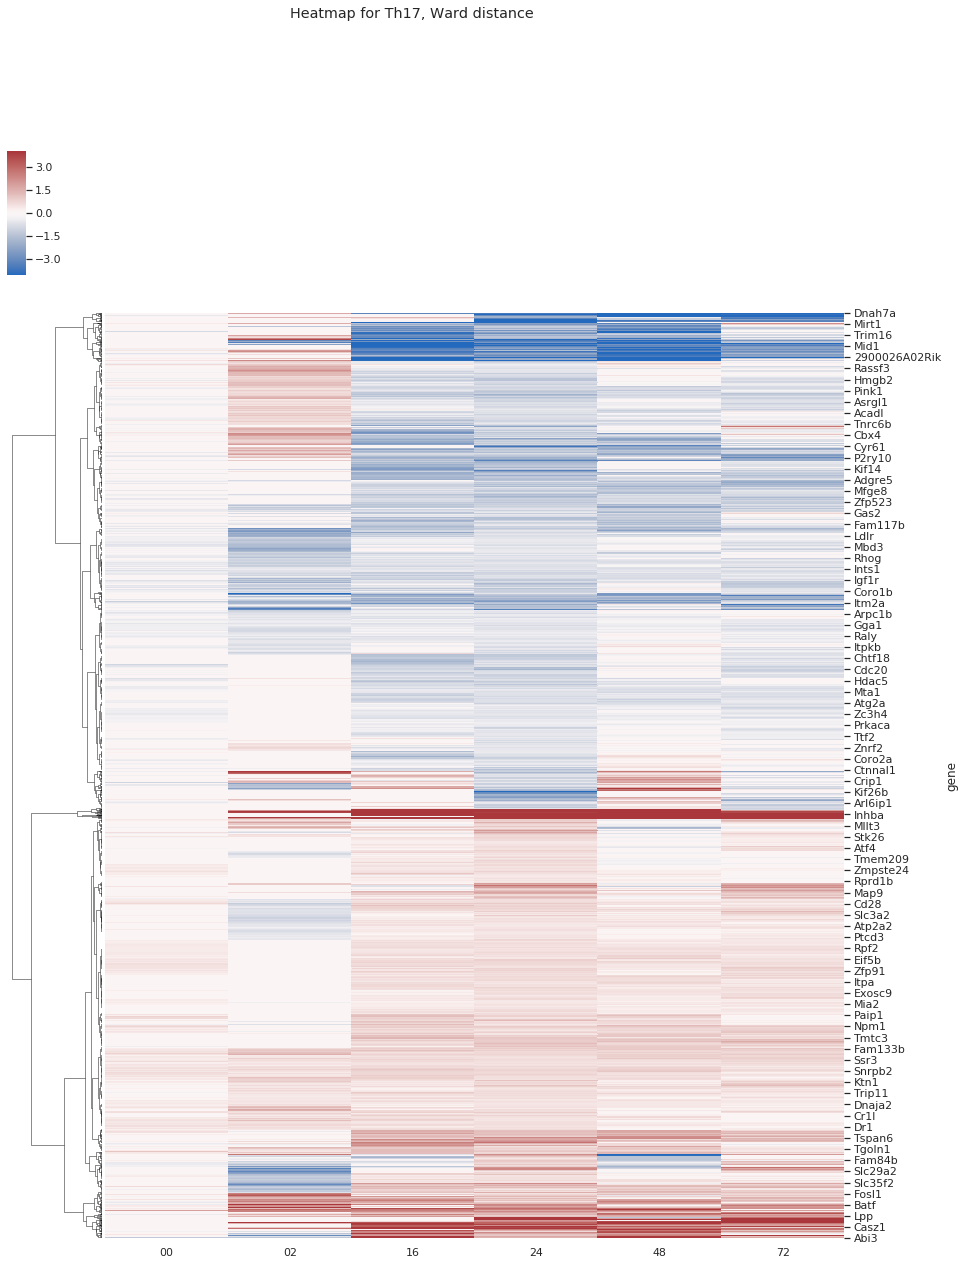

In [4]:
import scipy.cluster.hierarchy as sch
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set()

df = pd.read_csv("/data/reddylab/Revathy/dev/rna-seq_Siklenka/results/rna_seq/clustering/Th17.logFC.txt", sep="\t")
df = df.fillna(0)
df = df.head(2000)
df = df.set_index('gene')
cluster = sns.clustermap(df, method = 'ward', figsize=(15,20), cmap='vlag', vmin=-4, vmax=4, col_cluster=False).fig.suptitle('Heatmap for Th17, Ward distance') 
cluster.figure.savefig('/data/reddylab/Revathy/dev/rna-seq_Siklenka/results/rna_seq/clustering/Heatmap for Th17, Ward distance')
